In [6]:
import h5py
import os
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime


In [7]:
import os
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import yaml
import h5py
import random

class LocomotionDataset(Dataset):
    def __init__(self, folder_paths):
        """
        Initialize the LocomotionDataset.

        Args:
            folder_paths (list): List of paths to folders containing HDF5 files and metadata.
        """
        self.folder_paths = folder_paths
        self.metadata_list = [self._load_metadata(folder_path) for folder_path in folder_paths]
        # import ipdb; ipdb.set_trace()
        self.transformed_inputs = []
        self.transformed_targets = []
        self.folder_indices = []  # Track which folder each sample belongs to

        # Load and preprocess the dataset
        self._load_all_data()

    def _load_metadata(self, folder_path):
        """
        Load metadata from the YAML file in a dataset folder.

        Args:
            folder_path (str): Path to the folder.

        Returns:
            dict: Metadata containing environment parameters.
        """
        metadata_path = os.path.join(folder_path, "metadata.yaml")
        if not os.path.exists(metadata_path):
            raise FileNotFoundError(f"Metadata file not found at {metadata_path}")

        with open(metadata_path, "r") as metadata_file:
            metadata = yaml.safe_load(metadata_file)
        print(f"[INFO]: Loaded metadata from {metadata_path}")
        return metadata

    def _load_all_data(self):
        """
        Load and preprocess data from all specified folders.
        """
        for idx, folder_path in enumerate(self.folder_paths):
            hdf5_files = sorted(
                [f for f in os.listdir(folder_path) if f.endswith(".h5")],
                key=lambda x: int(x.split('_')[-1].split('.')[0])
            )

            if not hdf5_files:
                raise FileNotFoundError(f"No HDF5 files found in folder: {folder_path}")

            for file_name in hdf5_files:
                file_path = os.path.join(folder_path, file_name)
                print(f"[INFO]: Loading file {file_path}")

                with h5py.File(file_path, "r") as data_file:
                    inputs = data_file["one_policy_observation"][:]
                    targets = data_file["actions"][:]

                    # Validate data
                    if np.any(inputs == None) or np.any(targets == None):  # Check for None
                        raise ValueError(f"None values found in file: {file_path}")
                    if np.isnan(inputs).any() or np.isnan(targets).any():  # Check for NaN
                        raise ValueError(f"NaN values found in file: {file_path}")

                    # Flatten (N, 4096, D) into (N * 4096, D)
                    inputs = inputs.reshape(-1, inputs.shape[-1])  # Flatten sample dimension
                    targets = targets.reshape(-1, targets.shape[-1])  # Flatten sample dimension

                    # Transform and store components
                    for input_sample, target_sample in zip(inputs, targets):
                        components = self._transform_sample(input_sample, target_sample, self.metadata_list[idx])
                        self.transformed_inputs.append(components[:-1])  # Exclude target from inputs
                        self.transformed_targets.append(components[-1])  # Only store target separately
                        self.folder_indices.append(idx)  # Track folder index for each sample

        print(f"[INFO]: Preprocessed dataset with {len(self.transformed_inputs)} samples.")

    def _transform_sample(self, input_sample, target_sample, metadata):
        """
        Transform a single input and target sample into its components.

        Args:
            input_sample (np.ndarray): The input sample (shape: [D]).
            target_sample (np.ndarray): The target sample (shape: [T]).
            metadata (dict): Metadata for this sample.

        Returns:
            tuple: Transformed components.
        """
        state = torch.tensor(input_sample, dtype=torch.float32)  # Shape: (320,)
        target = torch.tensor(target_sample, dtype=torch.float32)  # Shape: (12,)

        # Dynamic Joint Data Transformation
        dynamic_joint_observation_length = metadata["dynamic_joint_observation_length"]
        nr_dynamic_joint_observations = metadata["nr_dynamic_joint_observations"]
        single_dynamic_joint_observation_length = metadata["single_dynamic_joint_observation_length"]
        dynamic_joint_description_size = metadata["dynamic_joint_description_size"]

        dynamic_joint_combined_state = state[..., :dynamic_joint_observation_length]  # Focus only on last dim
        dynamic_joint_combined_state = dynamic_joint_combined_state.view(
            nr_dynamic_joint_observations, single_dynamic_joint_observation_length
        )
        dynamic_joint_description = dynamic_joint_combined_state[..., :dynamic_joint_description_size]
        dynamic_joint_state = dynamic_joint_combined_state[..., dynamic_joint_description_size:]

        # Dynamic Foot Data Transformation
        dynamic_foot_observation_length = metadata["dynamic_foot_observation_length"]
        nr_dynamic_foot_observations = metadata["nr_dynamic_foot_observations"]
        single_dynamic_foot_observation_length = metadata["single_dynamic_foot_observation_length"]
        dynamic_foot_description_size = metadata["dynamic_foot_description_size"]

        dynamic_foot_start = dynamic_joint_observation_length
        dynamic_foot_end = dynamic_foot_start + dynamic_foot_observation_length
        dynamic_foot_combined_state = state[..., dynamic_foot_start:dynamic_foot_end]  # Focus only on last dim
        dynamic_foot_combined_state = dynamic_foot_combined_state.view(
            nr_dynamic_foot_observations, single_dynamic_foot_observation_length
        )
        dynamic_foot_description = dynamic_foot_combined_state[..., :dynamic_foot_description_size]
        dynamic_foot_state = dynamic_foot_combined_state[..., dynamic_foot_description_size:]

        # General Policy State Transformation
        general_policy_state = torch.cat([state[..., -17:-8], state[..., -7:]], dim=-1)

        # Return transformed inputs and target
        return (
            dynamic_joint_description,  # Shape: (nr_dynamic_joint_observations, dynamic_joint_description_size)
            dynamic_joint_state,        # Shape: (nr_dynamic_joint_observations, remaining_length)
            dynamic_foot_description,   # Shape: (nr_dynamic_foot_observations, dynamic_foot_description_size)
            dynamic_foot_state,         # Shape: (nr_dynamic_foot_observations, remaining_length)
            general_policy_state,       # Shape: (<concatenated_dim>)
            target                      # Shape: (12,)
        )

    def __len__(self):
        """
        Get the total number of samples in the dataset.
        """
        return len(self.transformed_inputs)

    # def __getitem__(self, index):
    #     """
    #     Get a preprocessed sample from the dataset at a specific index.

    #     Args:
    #         index (int): Index of the sample.

    #     Returns:
    #         tuple: Transformed inputs and target for the sample.
    #     """
    #     return (self.transformed_inputs[index], self.transformed_targets[index])

    def __getitem__(self, index):
        """
        Get a preprocessed sample from the dataset at a specific index.

        Args:
            index (int or list): Index of the sample(s).

        Returns:
            tuple: Transformed inputs and target for the sample(s).
        """
        # import ipdb; ipdb.set_trace()
        if isinstance(index, int):
            return (self.transformed_inputs[index], self.transformed_targets[index])
        else:
            return ([self.transformed_inputs[i] for i in index], self.transformed_targets[index])

    # def get_batch_indices(self, batch_size, shuffle=True):
    #     """
    #     Generate all indices for the dataset, ensuring batches come from the same folder.

    #     Args:
    #         batch_size (int): The size of each batch.
    #         shuffle (bool): Whether to shuffle the dataset.

    #     Returns:
    #         list: A list of lists, where each sublist contains indices for a batch.
    #     """
    #     if shuffle:
    #         indices = torch.randperm(len(self.folder_indices)).tolist()
    #     else:
    #         indices = list(range(len(self.folder_indices)))

    #     # Group indices by folder
    #     folder_to_indices = {}
    #     for idx in indices:
    #         folder = self.folder_indices[idx]
    #         if folder not in folder_to_indices:
    #             folder_to_indices[folder] = []
    #         folder_to_indices[folder].append(idx)

    #     # Create batches for each folder
    #     batch_indices = []
    #     for folder, folder_indices in folder_to_indices.items():
    #         for i in range(0, len(folder_indices), batch_size):
    #             batch_indices.append(folder_indices[i:i + batch_size])

    #     return batch_indices

    def get_batch_indices(self, batch_size, shuffle=True):
        """
        Generate all indices for the dataset, ensuring batches come from the same folder
        and merging them in the specified order.

        Args:
            batch_size (int): The size of each batch.
            shuffle (bool): Whether to shuffle the dataset.

        Returns:
            list: A list of indices, where each sublist contains indices for a batch.
        """
        # Group indices by folder
        folder_to_indices = {}
        for idx, folder in enumerate(self.folder_indices):
            if folder not in folder_to_indices:
                folder_to_indices[folder] = []
            folder_to_indices[folder].append(idx)

        # Chunk indices for each folder
        folder_batches = []
        for folder_indices in folder_to_indices.values():
            # Split folder indices into chunks of batch_size
            folder_chunks = [folder_indices[i:i + batch_size] for i in range(0, len(folder_indices) - batch_size, batch_size)]  # reduce the stop length by batch_size to avoid getting partial slice, which may bug sampler
            folder_batches.extend(folder_chunks)

        # Shuffle the list of batches (but not the contents of each batch)
        if shuffle:
            random.shuffle(folder_batches)

        # Flatten the list of batches to return a single list of indices
        merged_indices = [idx for batch in folder_batches for idx in batch]

        return merged_indices

    def collate_fn(self, batch):
        """
        Collate function to combine samples into a batch.

        Args:
            batch (list): List of samples, where each sample is a 2-tuple:
                        (inputs: 5-tuple, target: tensor).

        Returns:
            tuple: A 2-tuple where:
                - The first element is a 5-tuple of batched inputs.
                - The second element is the batched target tensor.
        """
        # Unpack inputs and targets
        inputs, targets = zip(*batch)  # inputs: list of 5-tuples, targets: list of tensors

        # Transpose the inputs to group by component
        inputs_by_component = zip(*inputs)  # Convert from list of 5-tuples to 5 lists

        # Stack each component of inputs along the batch dimension
        batched_inputs = tuple(torch.stack(component) for component in inputs_by_component)

        # Stack targets along the batch dimension
        batched_targets = torch.stack(targets)

        return batched_inputs, batched_targets

    def get_data_loader(self, batch_size, shuffle=True):
        """
        Create a DataLoader for the dataset.
        """
        sampler = torch.utils.data.sampler.BatchSampler(
            self.get_batch_indices(batch_size, shuffle),
            batch_size=batch_size,
            drop_last=False,
        )
        return DataLoader(self, batch_sampler=sampler, collate_fn=self.collate_fn)
    

In [8]:
def get_most_recent_h5py_record_path(base_path, task_name):
    """Find the most recent folder for a given task and return the path to its `h5py_record` subfolder."""
    task_path = os.path.join(base_path, task_name)

    if not os.path.exists(task_path):
        raise FileNotFoundError(f"Task folder '{task_name}' not found at {base_path}")

    subdirectories = [
        d for d in os.listdir(task_path)
        if os.path.isdir(os.path.join(task_path, d)) and d.replace("_", "-").replace("-", "").isdigit()
    ]

    if not subdirectories:
        raise FileNotFoundError(f"No subfolders found for task '{task_name}' in {task_path}")

    subdirectories.sort(key=lambda d: datetime.strptime(d, "%Y-%m-%d_%H-%M-%S"), reverse=True)
    most_recent_folder = subdirectories[0]

    h5py_record_path = os.path.join(task_path, most_recent_folder, "h5py_record")
    if not os.path.exists(h5py_record_path):
        raise FileNotFoundError(f"h5py_record folder not found in '{os.path.join(task_path, most_recent_folder)}'")

    return h5py_record_path

def my_get_most_recent_h5py_record_path(folder_path):
    """
    Find the most recent folder in a given path and load the contents of its `h5py_record` subfolder.
    
    Args:
        folder_path (str): The base folder containing subfolders with time-based names.
        
    Returns:
        dict: A dictionary of loaded datasets from the `h5py_record` subfolder.
    """
    if not os.path.exists(folder_path):
        raise FileNotFoundError(f"Folder '{folder_path}' not found.")

    subdirectories = [
        d for d in os.listdir(folder_path)
        if os.path.isdir(os.path.join(folder_path, d)) and d.replace("_", "-").replace("-", "").isdigit()
    ]

    if not subdirectories:
        raise FileNotFoundError(f"No subfolders found in '{folder_path}'.")

    # Sort subdirectories by datetime and find the most recent one
    subdirectories.sort(key=lambda d: datetime.strptime(d, "%Y-%m-%d_%H-%M-%S"), reverse=True)
    most_recent_folder = subdirectories[0]

    # Path to the `h5py_record` subfolder
    h5py_record_path = os.path.join(folder_path, most_recent_folder, "h5py_record")
    if not os.path.exists(h5py_record_path):
        raise FileNotFoundError(f"`h5py_record` folder not found in '{os.path.join(folder_path, most_recent_folder)}'")

    # Load datasets from the `h5py_record` folder
    data_dict = my_load_h5py_files(h5py_record_path)
    return data_dict


def my_load_h5py_files(folder_path):
    """
    Load datasets from all H5PY files in a folder and concatenate values with the same key.
    
    Args:
        folder_path (str): Path to the folder containing H5PY files.
        
    Returns:
        dict: A dictionary with dataset names as keys and concatenated data as values.
    """
    if not os.path.exists(folder_path):
        raise FileNotFoundError(f"Folder '{folder_path}' not found.")

    # import ipdb; ipdb.set_trace()
    # Dictionary to store concatenated data
    data_dict = {}
    
    # Get a sorted list of H5PY files in the folder
    h5py_files = sorted(
        [f for f in os.listdir(folder_path) if f.endswith(".h5") or f.endswith(".hdf5")]
    )
    if not h5py_files:
        raise ValueError(f"No H5PY files found in '{folder_path}'.")

    for file_name in h5py_files:
        file_path = os.path.join(folder_path, file_name)
        print(f"[INFO] Loading H5PY file: {file_path}")
        
        with h5py.File(file_path, 'r') as h5_file:
            for key in h5_file.keys():
                # Load data for the current key
                data = np.array(h5_file[key])
                
                # Concatenate data if the key already exists
                if key in data_dict:
                    data_dict[key] = np.concatenate((data_dict[key], data), axis=0)
                else:
                    data_dict[key] = data

    return data_dict

In [13]:
working_directory = os.getcwd()
if os.path.basename(working_directory) != "embodiment-scaling-law":
    working_directory = os.chdir(os.path.join(working_directory, "../", "../"))

In [16]:
dataset_dirs = [get_most_recent_h5py_record_path("logs/rsl_rl", task) for task in ["GenHumanoid1"]]
dataset = LocomotionDataset(folder_paths=dataset_dirs)
metadata = dataset.metadata_list[0]
# Extract keys ending with '_idx' and their associated indices
idx_keys = {key: metadata[key] for key in metadata if key.endswith('_idx')}

[INFO]: Loaded metadata from logs/rsl_rl/GenHumanoid1/2024-11-11_15-33-31/h5py_record/metadata.yaml
[INFO]: Loading file logs/rsl_rl/GenHumanoid1/2024-11-11_15-33-31/h5py_record/obs_actions_00000.h5
[INFO]: Preprocessed dataset with 819200 samples.


In [36]:
315+24+20

359

In [34]:
dataset.metadata_list[0]

{'dynamic_foot_description_size': 10,
 'dynamic_foot_observation_length': 24,
 'dynamic_joint_description_size': 18,
 'dynamic_joint_observation_length': 315,
 'foot_ground_contact_update_obs_idx': [325, 337],
 'foot_time_since_last_ground_contact_update_obs_idx': [326, 338],
 'goal_velocity_update_obs_idx': [345, 346, 347],
 'height_update_obs_idx': [351],
 'joint_positions_update_obs_idx': [18,
  39,
  60,
  81,
  102,
  123,
  144,
  165,
  186,
  207,
  228,
  249,
  270,
  291,
  312],
 'joint_previous_actions_update_obs_idx': [20,
  41,
  62,
  83,
  104,
  125,
  146,
  167,
  188,
  209,
  230,
  251,
  272,
  293,
  314],
 'joint_velocities_update_obs_idx': [19,
  40,
  61,
  82,
  103,
  124,
  145,
  166,
  187,
  208,
  229,
  250,
  271,
  292,
  313],
 'nr_dynamic_foot_observations': 2,
 'nr_dynamic_joint_observations': 15,
 'projected_gravity_update_obs_idx': [348, 349, 350],
 'single_dynamic_foot_observation_length': 12,
 'single_dynamic_joint_observation_length': 21,
 

In [7]:
input_list , target_list = [], []
for i in range(100000):
    inputs, targets = dataset[i]
    input_list.append(inputs)
    target_list.append(targets)

print(len(input_list), len(target_list))

100000 100000


In [8]:
def merge_tuples_to_batch_tensor(input_list):
    """
    Merge components of 5-tuples in a list into batches for PyTorch tensors.
    
    Args:
        input_list (list): A list of 5-tuples, where each tuple contains PyTorch tensors.
        
    Returns:
        tuple: A 5-tuple where each component is a batched tensor formed by stacking the corresponding components.
    """
    if not input_list or not isinstance(input_list[0], tuple) or len(input_list[0]) != 5:
        raise ValueError("Input must be a list of 5-tuples.")

    # Use zip to group each component across tuples, and stack tensors
    batched_components = tuple(torch.stack(components, dim=0) for components in zip(*input_list))
    
    return batched_components

inputs = merge_tuples_to_batch_tensor(input_list)

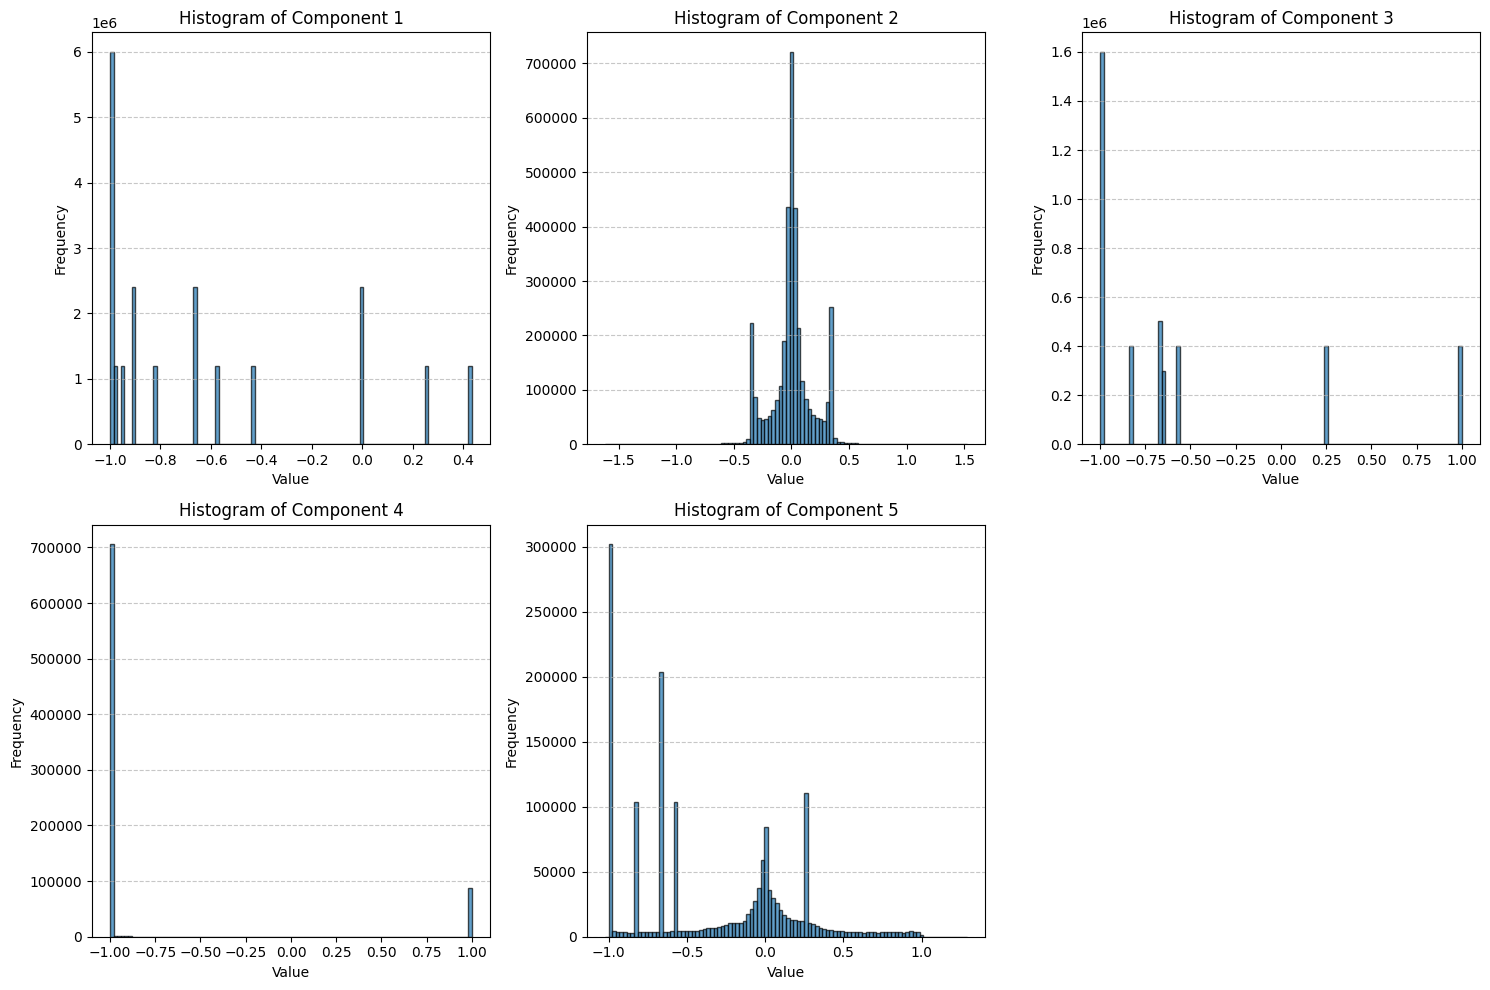

In [9]:
# Plot histograms for each component
plt.figure(figsize=(15, 10))
for i, component in enumerate(inputs):
    plt.subplot(2, 3, i + 1)  # Arrange subplots in a grid (2 rows, 3 columns)
    plt.hist(component.flatten().numpy(), bins=100, edgecolor='black', alpha=0.7)
    plt.title(f"Histogram of Component {i + 1}")
    plt.xlabel("Value")
    plt.ylabel("Frequency")
    plt.grid(axis='y', linestyle='--', alpha=0.7)

# Adjust layout
plt.tight_layout()
plt.show()

In [ ]:
plt.hist(inputs.flatten().tolist())

torch.Tensor

In [51]:
len(input_list), len(input_list[0])

(100, 5)

In [50]:
inputs = torch.cat(input_list, dim=0)
targets = torch.cat(target_list, dim=0)
print(inputs.shape, targets.shapeA)

TypeError: expected Tensor as element 0 in argument 0, but got tuple

In [40]:
state_dict = my_get_most_recent_h5py_record_path(h5py_file_path)
# Extract and aggregate the data
actions = state_dict['actions']  # Shape: (200, 4096, 12)
observations = state_dict['one_policy_observation']  # Shape: (200, 4096, 359)

# Aggregate by averaging along the 4096 dimension (axis 1)
aggregated_actions = actions[:, 0, :]  # Shape: (200, 12)
aggregated_observations = observations[:, 0, :]  # Shape: (200, 359)

[INFO] Loading H5PY file: logs/rsl_rl/GenDog2/2024-11-11_12-21-42/h5py_record/obs_actions_00000.h5
[INFO] Loading H5PY file: logs/rsl_rl/GenDog2/2024-11-11_12-21-42/h5py_record/obs_actions_00001.h5
[INFO] Loading H5PY file: logs/rsl_rl/GenDog2/2024-11-11_12-21-42/h5py_record/obs_actions_00002.h5
[INFO] Loading H5PY file: logs/rsl_rl/GenDog2/2024-11-11_12-21-42/h5py_record/obs_actions_00003.h5
[INFO] Loading H5PY file: logs/rsl_rl/GenDog2/2024-11-11_12-21-42/h5py_record/obs_actions_00004.h5


In [41]:
idx_keys

{'foot_ground_contact_update_obs_idx': [325, 337],
 'foot_time_since_last_ground_contact_update_obs_idx': [326, 338],
 'goal_velocity_update_obs_idx': [345, 346, 347],
 'height_update_obs_idx': [351],
 'joint_positions_update_obs_idx': [18,
  39,
  60,
  81,
  102,
  123,
  144,
  165,
  186,
  207,
  228,
  249,
  270,
  291,
  312],
 'joint_previous_actions_update_obs_idx': [20,
  41,
  62,
  83,
  104,
  125,
  146,
  167,
  188,
  209,
  230,
  251,
  272,
  293,
  314],
 'joint_velocities_update_obs_idx': [19,
  40,
  61,
  82,
  103,
  124,
  145,
  166,
  187,
  208,
  229,
  250,
  271,
  292,
  313],
 'projected_gravity_update_obs_idx': [348, 349, 350],
 'trunk_angular_vel_update_obs_idx': [342, 343, 344],
 'trunk_linear_vel_update_obs_idx': [339, 340, 341]}

In [42]:
state_dict['one_policy_observation'].shape

(1000, 4096, 320)

In [43]:
def transform_sample(input_sample, target_sample, metadata):
    """
    Transform a single input and target sample into its components.

    Args:
        input_sample (np.ndarray): The input sample (shape: [D]).
        target_sample (np.ndarray): The target sample (shape: [T]).
        metadata (dict): Metadata for this sample.

    Returns:
        tuple: Transformed components.
    """
    state = torch.tensor(input_sample, dtype=torch.float32)  # Shape: (320,)
    target = torch.tensor(target_sample, dtype=torch.float32)  # Shape: (12,)

    # Dynamic Joint Data Transformation
    dynamic_joint_observation_length = metadata["dynamic_joint_observation_length"]
    nr_dynamic_joint_observations = metadata["nr_dynamic_joint_observations"]
    single_dynamic_joint_observation_length = metadata["single_dynamic_joint_observation_length"]
    dynamic_joint_description_size = metadata["dynamic_joint_description_size"]

    dynamic_joint_combined_state = state[..., :dynamic_joint_observation_length]  # Focus only on last dim
    dynamic_joint_combined_state = dynamic_joint_combined_state.view(
        nr_dynamic_joint_observations, single_dynamic_joint_observation_length
    )
    dynamic_joint_description = dynamic_joint_combined_state[..., :dynamic_joint_description_size]
    dynamic_joint_state = dynamic_joint_combined_state[..., dynamic_joint_description_size:]

    # Dynamic Foot Data Transformation
    dynamic_foot_observation_length = metadata["dynamic_foot_observation_length"]
    nr_dynamic_foot_observations = metadata["nr_dynamic_foot_observations"]
    single_dynamic_foot_observation_length = metadata["single_dynamic_foot_observation_length"]
    dynamic_foot_description_size = metadata["dynamic_foot_description_size"]

    dynamic_foot_start = dynamic_joint_observation_length
    dynamic_foot_end = dynamic_foot_start + dynamic_foot_observation_length
    dynamic_foot_combined_state = state[..., dynamic_foot_start:dynamic_foot_end]  # Focus only on last dim
    dynamic_foot_combined_state = dynamic_foot_combined_state.view(
        nr_dynamic_foot_observations, single_dynamic_foot_observation_length
    )
    dynamic_foot_description = dynamic_foot_combined_state[..., :dynamic_foot_description_size]
    dynamic_foot_state = dynamic_foot_combined_state[..., dynamic_foot_description_size:]

    # General Policy State Transformation
    general_policy_state = torch.cat([state[..., -17:-8], state[..., -7:]], dim=-1)

    # Return transformed inputs and target
    return (
        dynamic_joint_description,  # Shape: (nr_dynamic_joint_observations, dynamic_joint_description_size)
        dynamic_joint_state,        # Shape: (nr_dynamic_joint_observations, remaining_length)
        dynamic_foot_description,   # Shape: (nr_dynamic_foot_observations, dynamic_foot_description_size)
        dynamic_foot_state,         # Shape: (nr_dynamic_foot_observations, remaining_length)
        general_policy_state,       # Shape: (<concatenated_dim>)
        target                      # Shape: (12,)
    )

In [44]:
state_dict['one_policy_observation'][0, 0].shape

(320,)

In [45]:
state_dict['actions'][0][0].shape

(12,)

In [46]:
transform_sample(state_dict['one_policy_observation'][0, 0], state_dict['actions'][0][0], metadata)

RuntimeError: shape '[2, 12]' is invalid for input of size 5

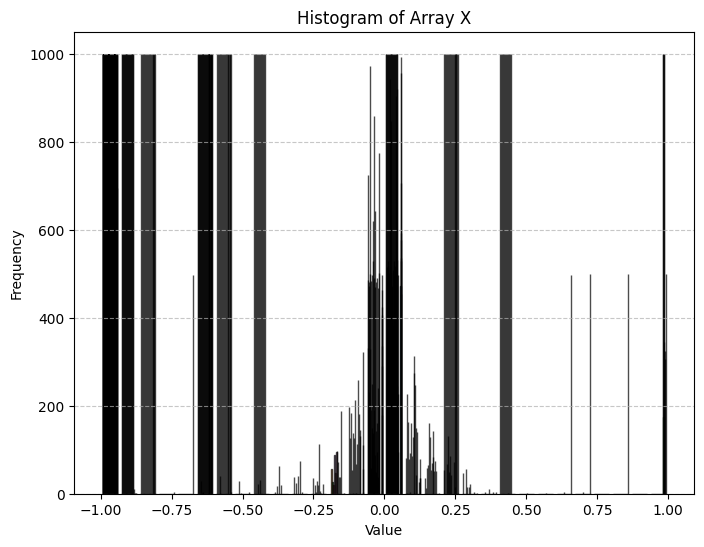

In [ ]:
X = state_dict['one_policy_observation'][:, 0]

# Plot the histogram
plt.figure(figsize=(8, 6))
plt.hist(X, bins=30, edgecolor='black', alpha=0.7)
plt.title("Histogram of Array X")
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


In [ ]:
state_dict['one_policy_observation'][:, 0, idx_keys['height_update_obs_idx']]

IndexError: index 351 is out of bounds for axis 2 with size 320

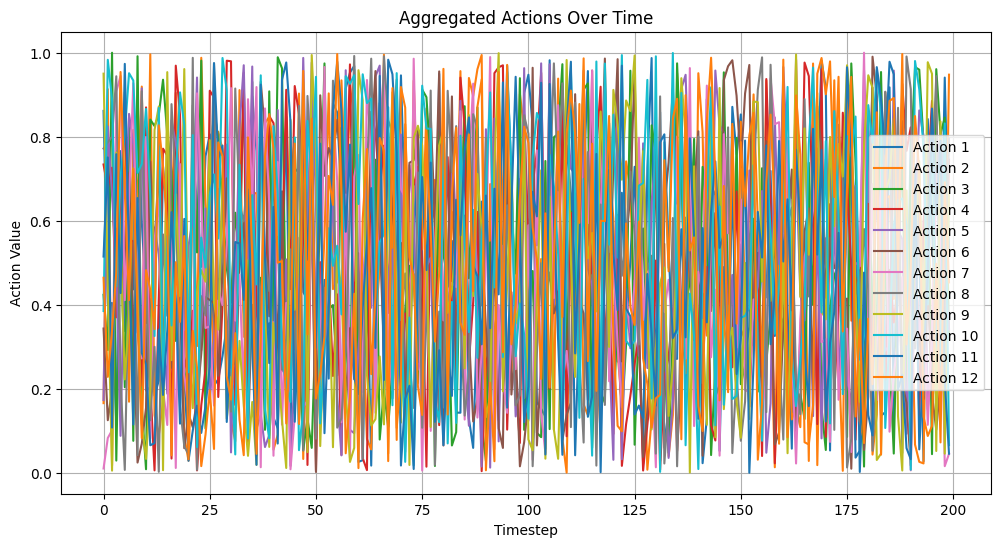

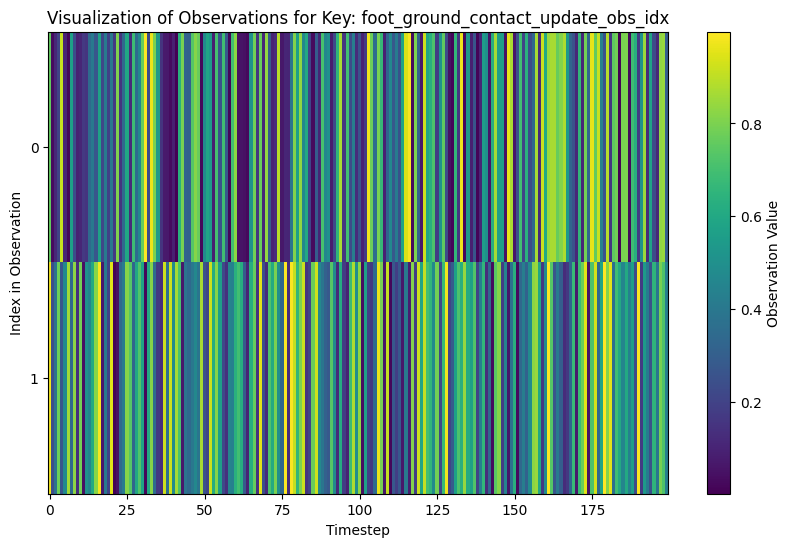

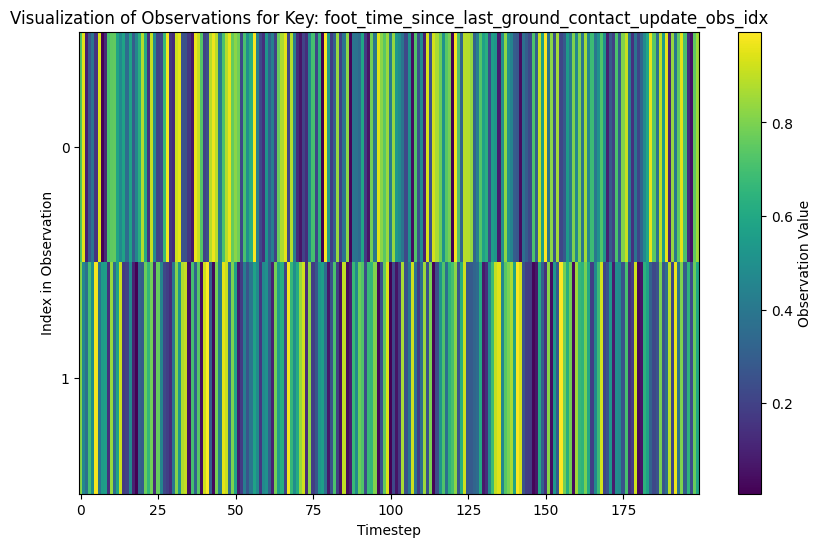

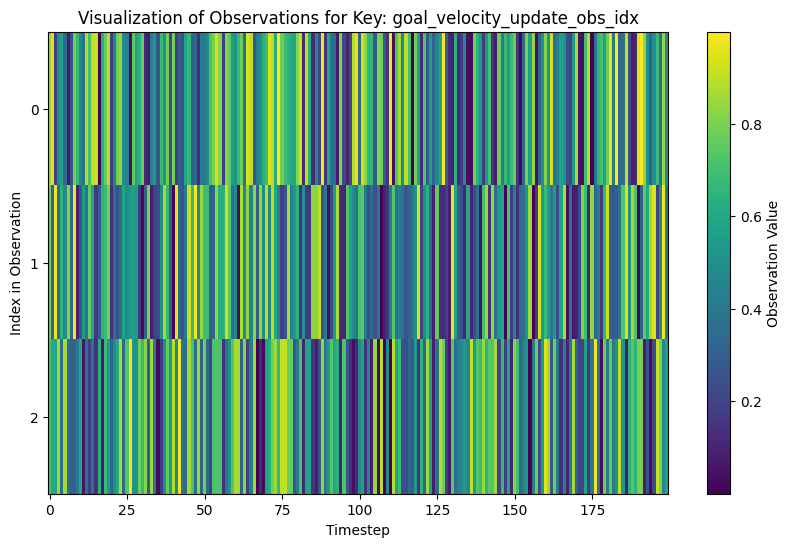

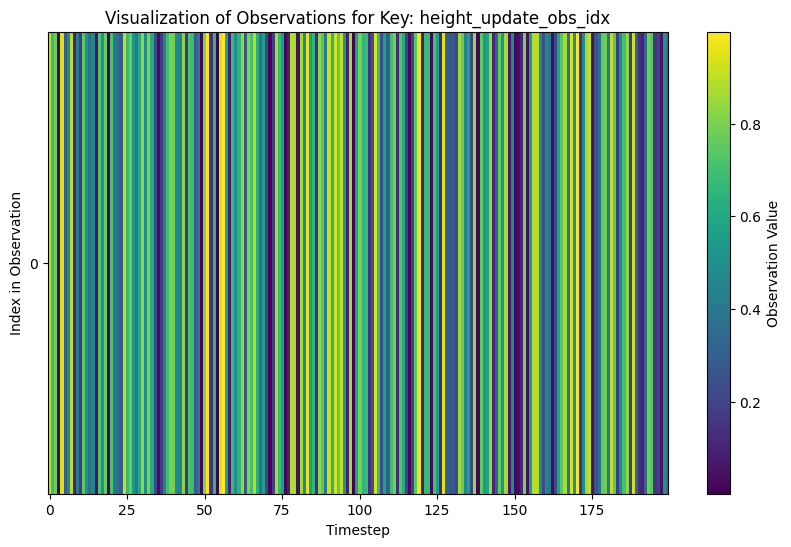

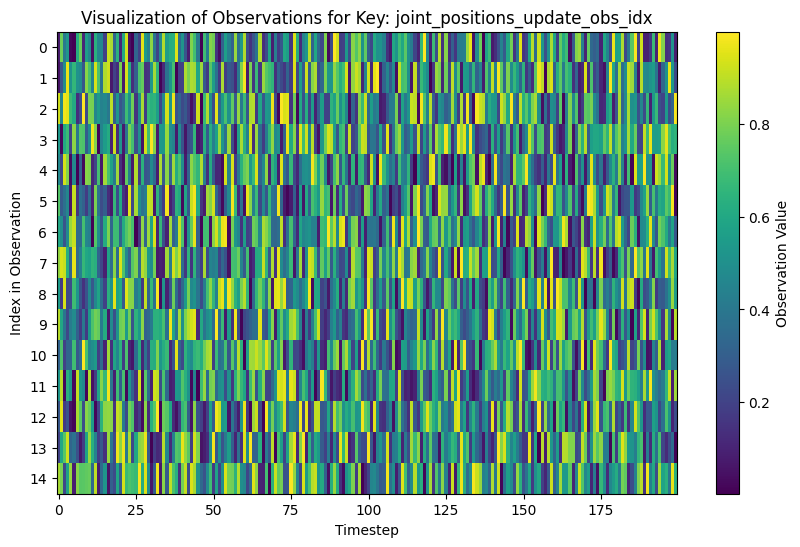

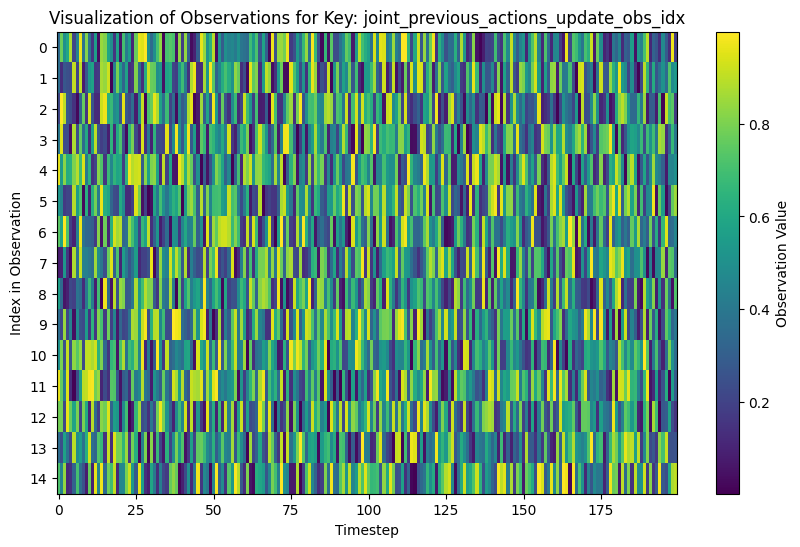

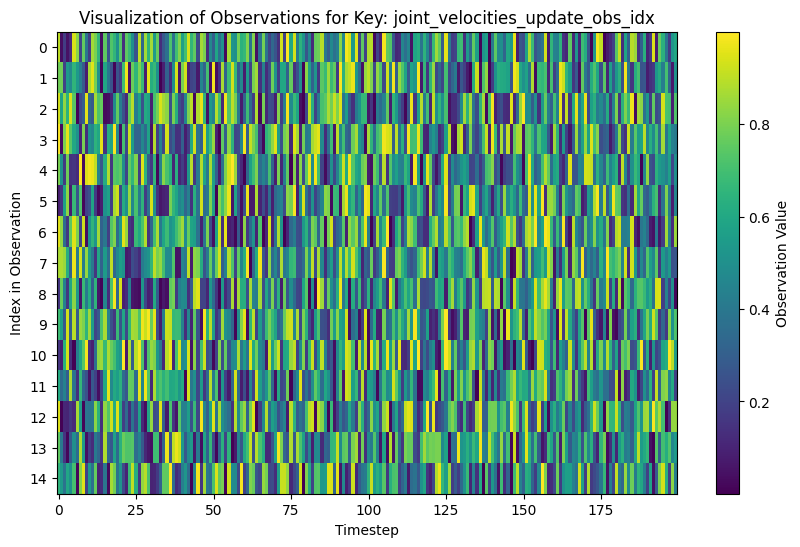

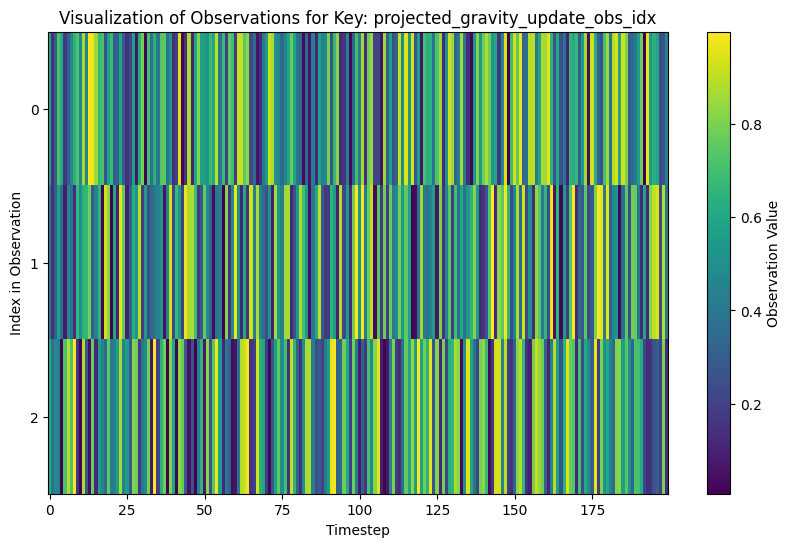

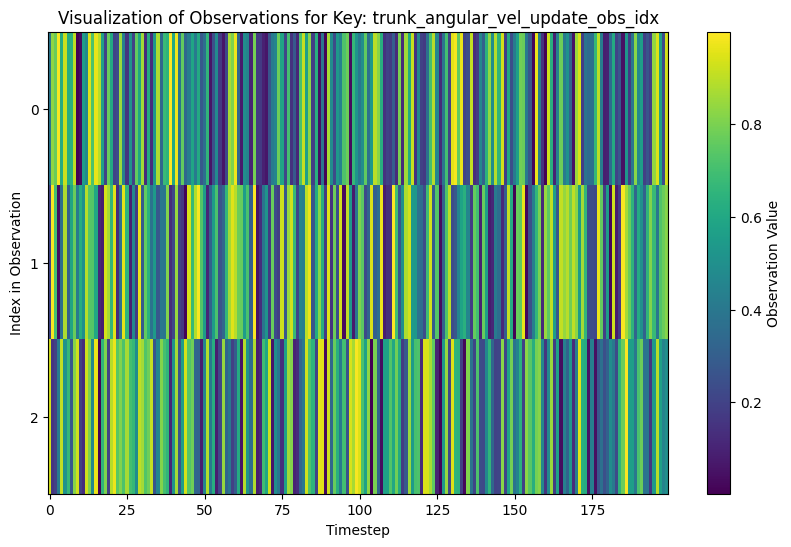

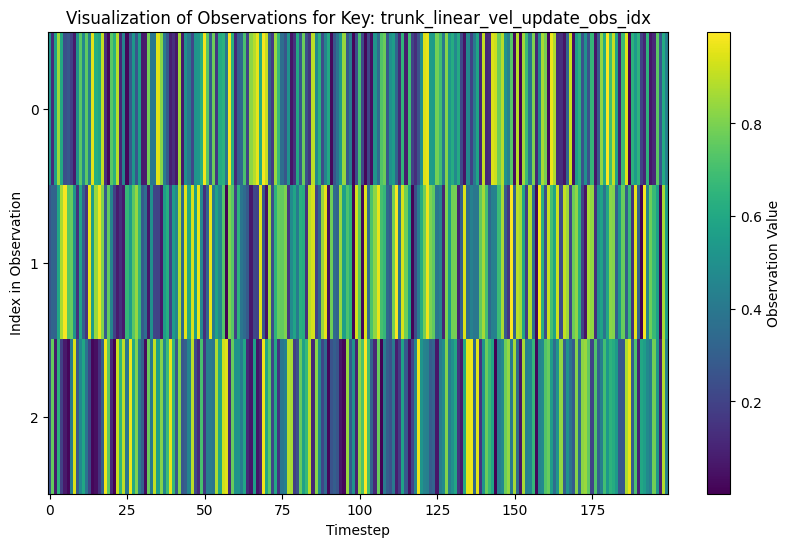

In [ ]:
# Plot aggregated actions
plt.figure(figsize=(12, 6))
for i in range(aggregated_actions.shape[1]):  # Iterate over 12 action dimensions
    plt.plot(aggregated_actions[:, i], label=f"Action {i+1}")
plt.title("Aggregated Actions Over Time")
plt.xlabel("Timestep")
plt.ylabel("Action Value")
plt.legend()
plt.grid()
plt.show()

for key, indices in idx_keys.items():
    # Ensure indices are a list for consistency
    if not isinstance(indices, (list, np.ndarray)):
        indices = [indices]
    
    # Extract data for the given indices
    selected_data = aggregated_observations[:, indices]  # Shape: (200, len(indices))
    
    # Plot heatmap for the selected data
    plt.figure(figsize=(10, 6))
    for i in selected_data.shape[1]:
        plt.plot(selected_data[:, i], aspect='auto', cmap='viridis')
        plt.colorbar(label="Observation Value")
        plt.title(f"Visualization of Observations for Key: {key}")
        plt.xlabel("Timestep")
        plt.ylabel("Index in Observation")
        plt.yticks(ticks=range(len(indices)))  # Display indices as y-axis labels
        plt.grid(False)
        plt.show()